In [1]:
import pandas as pd
import monai
import os
import torch
import numpy as np
import yaml
import datetime


import Pytorch_monai.Model_and_transforms as MF
import Pytorch_monai.Utils as Utils

In [2]:

with open('config_Small.yaml', 'r') as ymlfile:
    cfg = yaml.safe_load(ymlfile)


test_label_file = cfg['testing']['test_label_file_pruned']
train_label_file = cfg['training']['train_label_file']
output_folder = cfg['testing']['output_folder']
x_image_size = cfg['data_preparation']['image_size_x']
y_image_size = cfg['data_preparation']['image_size_y']
out_file = '.testing/acePredicitons/Predictions_DDS_model_epochs100_time_2023-09-28_08:28:09.239463/Predictions_DDS_model_epochs100_time_2023-09-28_08:28:09.239463.csv'

In [3]:
out_file_folder = out_file.split('/')[:-1]
out_file_folder = str.join('/',out_file_folder)

In [4]:
modelname = out_file.split('/')[-1].split(':')[0:-1]

In [5]:
modelname = str.join(':',modelname)
modelname

'Predictions_DDS_model_epochs100_time_2023-09-28_08:28'

In [42]:
ResultFrame = pd.read_csv(out_file)

In [43]:
ResultFrame.head(10)

,imageID,prediction,raw_0,raw_1,raw_2,raw_3,raw_4
0,/trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...,0,1.000000,2.100000e-44,4.921047e-37,0.000000e+00,1.293948e-37
1,/trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...,0,1.000000,0.000000e+00,1.753400e-41,0.000000e+00,2.820510e-32
2,/trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...,0,1.000000,0.000000e+00,5.046000e-42,0.000000e+00,5.458245e-39
3,/trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...,0,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,/trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...,0,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,/trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...,0,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6,/trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...,0,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7,/trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...,0,1.000000,1.277762e-37,3.465948e-27,0.000000e+00,7.345387e-14
8,/trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...,4,0.120757,2.324230e-25,3.113691e-16,6.322762e-31,8.792428e-01
9,/trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...,0,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [44]:
def splitImageID1(imageID):
    sliceName = imageID.split('/')[-1].split('.nii.gz')[0]
    NIFTI_name = sliceName.split('__s')[0]
    slicenum = sliceName.split('__s')[1]
    return NIFTI_name

def splitImageID2(imageID):
    sliceName = imageID.split('/')[-1].split('.nii.gz')[0]
    NIFTI_name = sliceName.split('__s')[0]
    slicenum = sliceName.split('__s')[1]
    return slicenum

def splitImageID(dataframe):
    imageID = dataframe['imageID']
    sliceName = imageID.split('/')[-1].split('.nii.gz')[0]
    NIFTI_name = sliceName.split('__s')[0]
    slicenum = sliceName.split('__s')[1]
    NIFTI_path = imageID.split(NIFTI_name)[0]
    NIFTI_path = NIFTI_path.replace('NIFTI_SLICES','NIFTI')
    NIFTI_path = os.path.normpath(f'{NIFTI_path}{NIFTI_name}.nii.gz')
    return pd.Series([NIFTI_path, NIFTI_name, slicenum], index=['NIFTI_path', 'NIFTI_name', 'slicenum'])

In [45]:
# ResultFrame['NIFTI_name']= ResultFrame['imageID'].apply(splitImageID1)
# ResultFrame['slicenum'] = ResultFrame['imageID'].apply(splitImageID2)
extraFrame = ResultFrame.apply(splitImageID, axis=1)
extraFrame.head()

,NIFTI_path,NIFTI_name,slicenum
0,/trinity/home/r098375/DDS/XNAT/NIFTI/ACE00482/...,20140102__MR__1.2.826.0.1.3680043.10.104.19370...,17
1,/trinity/home/r098375/DDS/XNAT/NIFTI/ACE00482/...,20140102__MR__1.2.826.0.1.3680043.10.104.19370...,19
2,/trinity/home/r098375/DDS/XNAT/NIFTI/ACE00482/...,20140102__MR__1.2.826.0.1.3680043.10.104.19370...,12
3,/trinity/home/r098375/DDS/XNAT/NIFTI/ACE00482/...,20140102__MR__1.2.826.0.1.3680043.10.104.19370...,4
4,/trinity/home/r098375/DDS/XNAT/NIFTI/ACE00482/...,20140102__MR__1.2.826.0.1.3680043.10.104.19370...,22


In [46]:
ResultFrame = ResultFrame.merge(extraFrame, how='left', left_index=True, right_index=True, validate='one_to_one')

In [47]:
NumSlicesPerClass=ResultFrame['slicenum'].nunique()
print(NumSlicesPerClass)

25


In [48]:
ResultFrame = ResultFrame.set_index(['NIFTI_name'],drop=True)

In [49]:
ResultFrame = ResultFrame.sort_index()

In [50]:
ResultFrame.head()

,imageID,prediction,raw_0,raw_1,raw_2,raw_3,raw_4,NIFTI_path,slicenum
NIFTI_name,,,,,,,,,
20111219__MR__1.2.826.0.1.3680043.10.104.2232086192778904528348267589020875266__1.2.826.0.1.3680043.10.104.2013796187791046302619232712294938590,/trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...,3,1.790698e-07,7.839330e-40,1.249091e-22,9.999998e-01,2.031120e-23,/trinity/home/r098375/DDS/XNAT/NIFTI/ACE00317/...,12
20111219__MR__1.2.826.0.1.3680043.10.104.2232086192778904528348267589020875266__1.2.826.0.1.3680043.10.104.2013796187791046302619232712294938590,/trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...,0,1.000000e+00,0.000000e+00,1.057000e-42,7.000000e-45,0.000000e+00,/trinity/home/r098375/DDS/XNAT/NIFTI/ACE00317/...,17
20111219__MR__1.2.826.0.1.3680043.10.104.2232086192778904528348267589020875266__1.2.826.0.1.3680043.10.104.2013796187791046302619232712294938590,/trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...,1,2.307837e-24,1.000000e+00,1.782268e-18,1.412259e-10,3.439293e-26,/trinity/home/r098375/DDS/XNAT/NIFTI/ACE00317/...,3
20111219__MR__1.2.826.0.1.3680043.10.104.2232086192778904528348267589020875266__1.2.826.0.1.3680043.10.104.2013796187791046302619232712294938590,/trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...,1,2.678712e-12,1.000000e+00,1.143033e-17,5.726482e-16,7.335551e-31,/trinity/home/r098375/DDS/XNAT/NIFTI/ACE00317/...,4
20111219__MR__1.2.826.0.1.3680043.10.104.2232086192778904528348267589020875266__1.2.826.0.1.3680043.10.104.2013796187791046302619232712294938590,/trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...,3,5.030955e-27,0.000000e+00,5.596899e-32,1.000000e+00,3.189684e-33,/trinity/home/r098375/DDS/XNAT/NIFTI/ACE00317/...,11


In [52]:
ResultFrame.describe()

,prediction,raw_0,raw_1,raw_2,raw_3,raw_4
count,12375.000000,12375.000000,12375.000000,1.237500e+04,12375.000000,1.237500e+04
mean,0.349010,0.881801,0.029532,3.813421e-08,0.034659,5.400830e-02
std,1.039763,0.320774,0.167784,3.779423e-06,0.181885,2.239457e-01
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
50%,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
75%,0.000000,1.000000,0.000000,5.936205e-40,0.000000,2.523402e-38
max,4.000000,1.000000,1.000000,4.194058e-04,1.000000,1.000000e+00


In [53]:
ResultFrame['groundTruth'] = 0 #this is just because of only having the T1 images in the ace pred

In [54]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from seaborn import heatmap
import seaborn as sns
import matplotlib.pyplot as plt

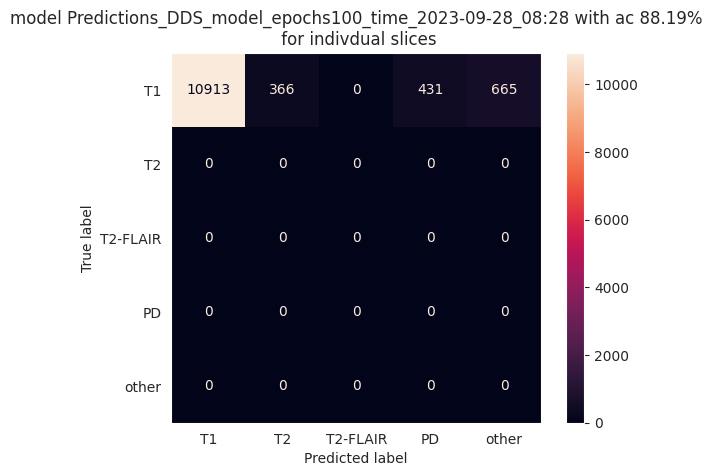

In [55]:
mc = confusion_matrix(y_true=ResultFrame['groundTruth'],y_pred=ResultFrame['prediction'],labels=[0,1,2,3,4])
ac = accuracy_score(y_true=ResultFrame['groundTruth'],y_pred=ResultFrame['prediction'])
# mc_display = ConfusionMatrixDisplay(mc,display_labels=['T1','T1_c','T2','FLAIR','seg'])
mc_display = ConfusionMatrixDisplay(mc,display_labels=['T1','T2','T2-FLAIR','PD','other'])
mc_display.plot(cmap='rocket')
plt.grid(False)
plt.title(f'model {modelname} with ac {ac*100:.2f}%\n for indivdual slices')
plt.savefig(os.path.join(os.path.split(out_file)[0],f'{modelname}_individualSlices_heatmap.png'))
plt.show()

In [56]:
def majorityVote(frame,N_classes):
    votes = np.zeros(N_classes)
    framelength = len(frame)
    for prediction in frame['prediction']:
        votes[prediction] += 1
    majorityClass = np.argmax(votes)
    certainty = np.max(votes)/framelength
    return pd.Series({'vote':majorityClass,'certainty':certainty})
        

In [57]:

VotingFrame = ResultFrame[['prediction']].groupby('NIFTI_name').apply(majorityVote,5)

In [58]:
VotingFrame

,vote,certainty
NIFTI_name,,
20111219__MR__1.2.826.0.1.3680043.10.104.2232086192778904528348267589020875266__1.2.826.0.1.3680043.10.104.2013796187791046302619232712294938590,0.0,0.52
20120126__MR__1.2.826.0.1.3680043.10.104.1046213942946388325415260488899842008__1.2.826.0.1.3680043.10.104.2344052865275355403703290963408158735,0.0,0.96
20120628__MR__1.2.826.0.1.3680043.10.104.2350295337007810006108763767101731386__1.2.826.0.1.3680043.10.104.2200030220066886121049217445512274685,0.0,1.00
20121122__MR__1.2.826.0.1.3680043.10.104.1284237159543654422273136113496315924__1.2.826.0.1.3680043.10.104.2492869673689677617853653995781802617,0.0,1.00
20130208__MR__1.2.826.0.1.3680043.10.104.1225449424390642340300785308177431642__1.2.826.0.1.3680043.10.104.7428696897141140622997974722721515623,0.0,0.84
...,...,...
20210205__MR__1.2.826.0.1.3680043.10.104.2064520388686029414788975871288191353__1.2.826.0.1.3680043.10.104.9794857099337957388138494922388210283,0.0,1.00
20210211__MR__1.2.826.0.1.3680043.10.104.9050425694368538091755581964161897393__1.2.826.0.1.3680043.10.104.2255121013503287461696401758612242733,0.0,1.00
20210218__MR__1.2.826.0.1.3680043.10.104.2253618676246641488970704325273584778__1.2.826.0.1.3680043.10.104.3021829445253809699706673721930283771,0.0,0.96


In [59]:
FullResultFrame = ResultFrame.merge(VotingFrame,how='left',on='NIFTI_name')

In [60]:
FullResultFrame

,imageID,prediction,raw_0,raw_1,raw_2,raw_3,raw_4,NIFTI_path,slicenum,groundTruth,vote,certainty
NIFTI_name,,,,,,,,,,,,
20111219__MR__1.2.826.0.1.3680043.10.104.2232086192778904528348267589020875266__1.2.826.0.1.3680043.10.104.2013796187791046302619232712294938590,/trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...,3,1.790698e-07,7.839330e-40,1.249091e-22,9.999998e-01,2.031120e-23,/trinity/home/r098375/DDS/XNAT/NIFTI/ACE00317/...,12,0,0.0,0.52
20111219__MR__1.2.826.0.1.3680043.10.104.2232086192778904528348267589020875266__1.2.826.0.1.3680043.10.104.2013796187791046302619232712294938590,/trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...,0,1.000000e+00,0.000000e+00,1.057000e-42,7.000000e-45,0.000000e+00,/trinity/home/r098375/DDS/XNAT/NIFTI/ACE00317/...,17,0,0.0,0.52
20111219__MR__1.2.826.0.1.3680043.10.104.2232086192778904528348267589020875266__1.2.826.0.1.3680043.10.104.2013796187791046302619232712294938590,/trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...,1,2.307837e-24,1.000000e+00,1.782268e-18,1.412259e-10,3.439293e-26,/trinity/home/r098375/DDS/XNAT/NIFTI/ACE00317/...,3,0,0.0,0.52
20111219__MR__1.2.826.0.1.3680043.10.104.2232086192778904528348267589020875266__1.2.826.0.1.3680043.10.104.2013796187791046302619232712294938590,/trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...,1,2.678712e-12,1.000000e+00,1.143033e-17,5.726482e-16,7.335551e-31,/trinity/home/r098375/DDS/XNAT/NIFTI/ACE00317/...,4,0,0.0,0.52
20111219__MR__1.2.826.0.1.3680043.10.104.2232086192778904528348267589020875266__1.2.826.0.1.3680043.10.104.2013796187791046302619232712294938590,/trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...,3,5.030955e-27,0.000000e+00,5.596899e-32,1.000000e+00,3.189684e-33,/trinity/home/r098375/DDS/XNAT/NIFTI/ACE00317/...,11,0,0.0,0.52
...,...,...,...,...,...,...,...,...,...,...,...,...
20210222__MR__1.2.826.0.1.3680043.10.104.3052513131466776863552534743545368335__1.2.826.0.1.3680043.10.104.1935242412895388186561381882057131129,/trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...,0,1.000000e+00,4.195466e-25,3.705539e-32,1.544648e-29,0.000000e+00,/trinity/home/r098375/DDS/XNAT/NIFTI/ACE04891/...,14,0,0.0,0.68
20210222__MR__1.2.826.0.1.3680043.10.104.3052513131466776863552534743545368335__1.2.826.0.1.3680043.10.104.1935242412895388186561381882057131129,/trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...,1,3.051516e-08,9.533900e-01,1.940174e-14,4.660993e-02,2.496629e-31,/trinity/home/r098375/DDS/XNAT/NIFTI/ACE04891/...,9,0,0.0,0.68
20210222__MR__1.2.826.0.1.3680043.10.104.3052513131466776863552534743545368335__1.2.826.0.1.3680043.10.104.1935242412895388186561381882057131129,/trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...,0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,/trinity/home/r098375/DDS/XNAT/NIFTI/ACE04891/...,20,0,0.0,0.68


In [66]:
FullResultFrame = FullResultFrame.set_index('slicenum',append=True).sort_index()
FullResultFrame.head(10)

imageID  \
NIFTI_name                                         slicenum                                                      
20111219__MR__1.2.826.0.1.3680043.10.104.223208... 0         /trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...   
                                                   1         /trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...   
                                                   10        /trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...   
                                                   11        /trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...   
                                                   12        /trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...   
                                                   13        /trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...   
                                                   14        /trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...   
                                                   15        /trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...   
                                                   16        /trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...   
                                                   17        /trinity/home/r098375/DDS/XNAT/NIFTI_SLICES/AC...   

                                                             prediction  \
NIFTI_name                                         slicenum               
20111219__MR__1.2.826.0.1.3680043.10.104.223208... 0                  1   
                                                   1                  1   
                                                   10                 3   
                                                   11                 3   
                                                   12                 3   
                                                   13                 0   
                                                   14                 0   
                                                   15                 0   
                                                   16                 0   
                                                   17                 0   

                                                                    raw_0  \
NIFTI_name                                         slicenum                 
20111219__MR__1.2.826.0.1.3680043.10.104.223208... 0         4.531981e-20   
                                                   1         3.035439e-29   
                                                   10        3.155563e-21   
                                                   11        5.030955e-27   
                                                   12        1.790698e-07   
                                                   13        1.000000e+00   
                                                   14        9.956921e-01   
                                                   15        1.000000e+00   
                                                   16        1.000000e+00   
                                                   17        1.000000e+00   

                                                                    raw_1  \
NIFTI_name                                         slicenum                 
20111219__MR__1.2.826.0.1.3680043.10.104.223208... 0         1.000000e+00   
                                                   1         1.000000e+00   
                                                   10        6.313374e-38   
                                                   11        0.000000e+00   
                                                   12        7.839330e-40   
                                                   13        2.232552e-32   
                                                   14        4.228063e-28   
                                                   15        2.066843e-35   
                                                   16        0.000000e+00   
                                                   17        

In [63]:
print(out_file_folder)

.testing/acePredicitons/Predictions_DDS_model_epochs100_time_2023-09-28_08:28:09.239463


In [65]:
FullResultFrame.to_csv(os.path.join(out_file_folder,f'{modelname}_ensamblePredictions.csv'),index=True)

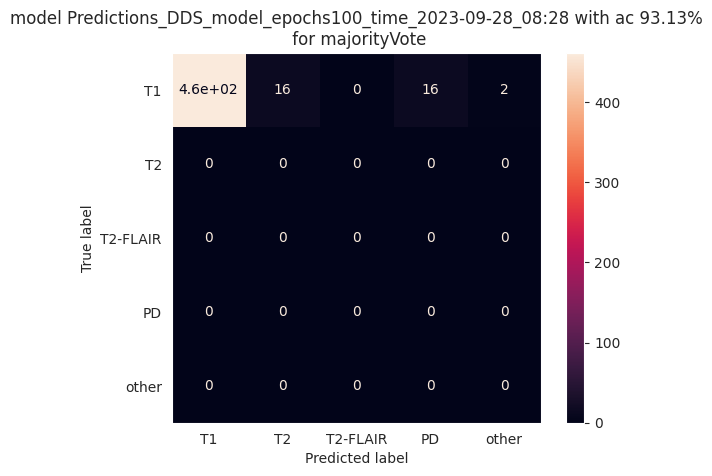

In [67]:
mc = confusion_matrix(y_true=FullResultFrame['groundTruth'],y_pred=FullResultFrame['vote'],labels=[0,1,2,3,4])
mc = mc/NumSlicesPerClass
ac = accuracy_score(y_true=FullResultFrame['groundTruth'],y_pred=FullResultFrame['vote'])
# mc_display = ConfusionMatrixDisplay(mc,display_labels=['T1','T1_c','T2','FLAIR','seg'])
mc_display = ConfusionMatrixDisplay(mc,display_labels=['T1','T2','T2-FLAIR','PD','other'])
mc_display.plot(cmap='rocket')
plt.grid(False)
plt.title(f'model {modelname} with ac {ac*100:.2f}%\n for majorityVote')
plt.savefig(os.path.join(os.path.split(out_file)[0],f'{modelname}_majorityVote_heatmap.png'))
plt.show()

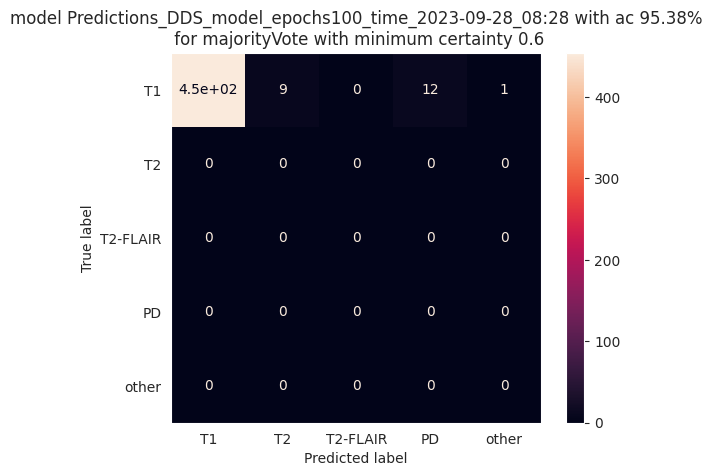

In [68]:
certaintyThreshhold = 0.6
mc = confusion_matrix(y_true=FullResultFrame['groundTruth'][FullResultFrame['certainty']>=certaintyThreshhold],y_pred=FullResultFrame['vote'][FullResultFrame['certainty']>=certaintyThreshhold],labels=[0,1,2,3,4])
mc = mc/NumSlicesPerClass
ac = accuracy_score(y_true=FullResultFrame['groundTruth'][FullResultFrame['certainty']>=certaintyThreshhold],y_pred=FullResultFrame['vote'][FullResultFrame['certainty']>=certaintyThreshhold])
# mc_display = ConfusionMatrixDisplay(mc,display_labels=['T1','T1_c','T2','FLAIR','seg'])
mc_display = ConfusionMatrixDisplay(mc,display_labels=['T1','T2','T2-FLAIR','PD','other'])
mc_display.plot(cmap='rocket')
plt.grid(False)
plt.title(f'model {modelname} with ac {ac*100:.2f}%\n for majorityVote with minimum certainty {certaintyThreshhold}')
plt.savefig(os.path.join(os.path.split(out_file)[0],f'{modelname}_majorityVote_withCertaintyOf{certaintyThreshhold}_heatmap.png'))
plt.show()

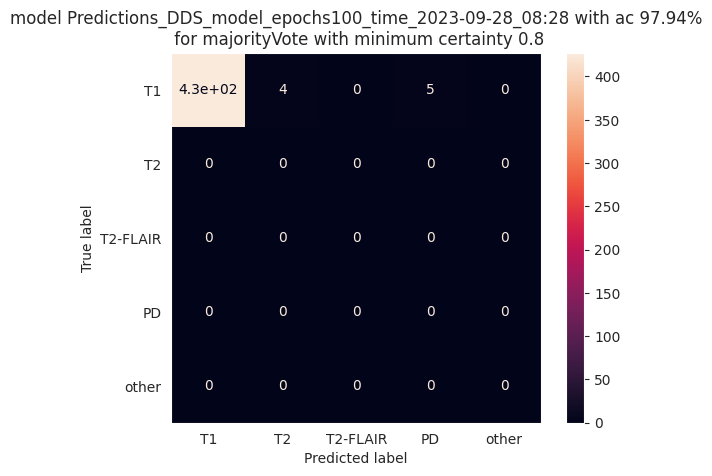

In [285]:
certaintyThreshhold = 0.8
mc = confusion_matrix(y_true=FullResultFrame['groundTruth'][FullResultFrame['certainty']>=certaintyThreshhold],y_pred=FullResultFrame['vote'][FullResultFrame['certainty']>=certaintyThreshhold],labels=[0,1,2,3,4])
mc = mc/NumSlicesPerClass
ac = accuracy_score(y_true=FullResultFrame['groundTruth'][FullResultFrame['certainty']>=certaintyThreshhold],y_pred=FullResultFrame['vote'][FullResultFrame['certainty']>=certaintyThreshhold])
# mc_display = ConfusionMatrixDisplay(mc,display_labels=['T1','T1_c','T2','FLAIR','seg'])
mc_display = ConfusionMatrixDisplay(mc,display_labels=['T1','T2','T2-FLAIR','PD','other'])
mc_display.plot(cmap='rocket')
plt.grid(False)
plt.title(f'model {modelname} with ac {ac*100:.2f}%\n for majorityVote with minimum certainty {certaintyThreshhold}')
plt.savefig(os.path.join(os.path.split(out_file)[0],f'{modelname}_majorityVote_withCertaintyOf{certaintyThreshhold}_heatmap.png'))
plt.show()

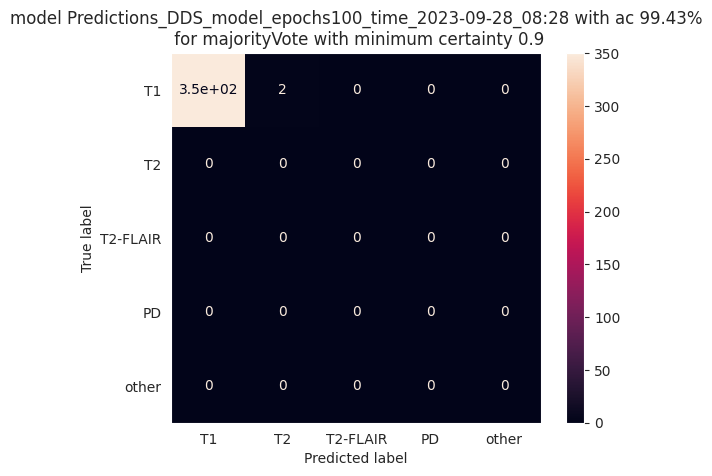

In [286]:
certaintyThreshhold = 0.9
mc = confusion_matrix(y_true=FullResultFrame['groundTruth'][FullResultFrame['certainty']>=certaintyThreshhold],y_pred=FullResultFrame['vote'][FullResultFrame['certainty']>=certaintyThreshhold],labels=[0,1,2,3,4])
mc = mc/NumSlicesPerClass
ac = accuracy_score(y_true=FullResultFrame['groundTruth'][FullResultFrame['certainty']>=certaintyThreshhold],y_pred=FullResultFrame['vote'][FullResultFrame['certainty']>=certaintyThreshhold])
# mc_display = ConfusionMatrixDisplay(mc,display_labels=['T1','T1_c','T2','FLAIR','seg'])
mc_display = ConfusionMatrixDisplay(mc,display_labels=['T1','T2','T2-FLAIR','PD','other'])
mc_display.plot(cmap='rocket')
plt.grid(False)
plt.title(f'model {modelname} with ac {ac*100:.2f}%\n for majorityVote with minimum certainty {certaintyThreshhold}')
plt.savefig(os.path.join(os.path.split(out_file)[0],f'{modelname}_majorityVote_withCertaintyOf{certaintyThreshhold}_heatmap.png'))
plt.show()